# Stack Exchange Popular Data Science Questions

## Narrowing Down `deep-learning` Tag

We use the following query to get all questions from SEDE. Our goal is to determine whether the `deep-learning` tag is a smart and long-lasting subject matter to base our top question upon.

```sql
SELECT Id, CreationDate, Tags
  FROM posts
 WHERE PostTypeId = 1;
```

This is saved into `all_questions.csv`

### Import `all_questions.csv` Into New DataFrame

In [185]:
df_all = pd.read_csv('all_questions.csv', parse_dates=['CreationDate'])

df_all.head()

,Id,CreationDate,Tags
0,87791,2021-01-11 09:32:20,<nlp><object-detection><document-understanding>
1,87792,2021-01-11 10:28:11,<python><scikit-learn><k-means>
2,87793,2021-01-11 10:29:08,<nlp><spacy><tokenization><information-extract...
3,87798,2021-01-11 11:29:28,<neural-network><lstm><overfitting>
4,87801,2021-01-11 12:07:36,<pytorch><torch>


### Clean `Tags` Column

We can use the same `clean_tags()` function that we created earlier in order to clean the new dataframe's `Tags` column.

In [186]:
df_all['Tags'] = df_all['Tags'].apply(clean_tags)

In this project, we set to identify the most popular data science questions from Stack Exchange by utilizing the Stack Exchange Data Explorer (SEDE). Our goal is to find the best category to pose a new question about.

## Initial SQL Exploration

We begin by exploring the tables within the SEDE. The `Posts` table seems to be the most relevant to our goal of finding the most popular questions. Using the following query, we can see the relevant columns within the table as well as sample rows.

```sql
SELECT TOP 10 *
FROM Posts;
```

<img src="screenshots/Screenshot 2024-12-17 142147.jpg"/>

Running the following gives us an explanation on Post Types:

```sql
SELECT *
FROM PostTypes;
```

<img src="screenshots/Screenshot 2024-12-17 142503.jpg"/>

Seeing this table, we can see that we want to narrow down our posts to the `PostTypeId` of 1 to only view questions.

## Get Relevant Data From `Questions` Post Type

The columns that we are targetting are:
- Id
- PostTypeId
- CreationDate
- Score
- ViewCount
- Tags
- AnswerCount
- FavoriteCount

---

### Questions from 2024

We can filter the Posts table with the necessary columns by `Questions` type with the following query, focusing on only posts that are within the current year (2024):

```sql
SELECT Id, CreationDate, Score, ViewCount, Tags, AnswerCount, FavoriteCount
FROM Posts
WHERE PostTypeId = 1 AND CreationDate >= '2024-01-01 00:00:00'
ORDER BY CreationDate DESC;
```

<img src="screenshots/Screenshot 2024-12-17 142904.jpg"/>

---

### Dynamic: Questions from last 12 months

We can even convert this into a dynamic query that will pull a years worth of data regardless of the current date.

```sql
SELECT Id, CreationDate, Score, ViewCount, Tags, AnswerCount, FavoriteCount
FROM Posts
WHERE PostTypeId = 1 AND CreationDate >= DATEADD(MONTH, -12, GETDATE())
ORDER BY CreationDate DESC;
```

<img src="screenshots/Screenshot 2024-12-17 143717.jpg"/>

Using this resulting table, we will download it as a `.csv` and analyze our results further.

## Data Exploration Using Python

In [187]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

df = pd.read_csv('2024_questions.csv', parse_dates=['CreationDate'])

In [188]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2082 entries, 0 to 2081
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             2082 non-null   int64         
 1   CreationDate   2082 non-null   datetime64[ns]
 2   Score          2082 non-null   int64         
 3   ViewCount      2082 non-null   int64         
 4   Tags           2082 non-null   object        
 5   AnswerCount    2082 non-null   int64         
 6   FavoriteCount  0 non-null      float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 114.0+ KB


In [189]:
df.head()

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,130937,2024-12-14 19:42:10,0,7,<scikit-learn><random-forest><overfitting><for...,0,NaN
1,130935,2024-12-14 06:21:49,0,10,<neural-network><pytorch><overfitting>,0,NaN
2,130931,2024-12-13 17:58:34,0,54,<scikit-learn><xgboost>,1,NaN
3,130928,2024-12-13 15:36:20,0,12,<python><pytorch><forecasting><attention-mecha...,0,NaN
4,130927,2024-12-13 15:34:17,1,16,<dataset><data-mining><data><visualization><da...,1,NaN


In [190]:
df.isnull().sum()

Id                  0
CreationDate        0
Score               0
ViewCount           0
Tags                0
AnswerCount         0
FavoriteCount    2082
dtype: int64

In [191]:
df['FavoriteCount'].value_counts(dropna=False)

FavoriteCount
NaN    2082
Name: count, dtype: int64

In [192]:
df['Tags'].value_counts(dropna=False)

Tags
<machine-learning>                                                17
<deep-learning>                                                    8
<machine-learning><python><deep-learning><neural-network><nlp>     8
<time-series>                                                      7
<dataset>                                                          6
                                                                  ..
<python><bayesian><monte-carlo>                                    1
<machine-learning><time-series><forecasting>                       1
<data-cleaning>                                                    1
<python><xgboost><multiclass-classification>                       1
<machine-learning><time-series><regression>                        1
Name: count, Length: 1856, dtype: int64

### Findings:
- Null values in `FavoriteCount`
    - All values are null in this case
- `Tags` column needs cleaning
    - Change formatting from brackets to comma-separated
    - Store in list

## Data Cleaning

Because all values within `FavoriteCount` are null in this case, we can drop the column within this dataset.

In [193]:
df.drop(columns=['FavoriteCount'], axis=1, inplace=True)

Now we can continue with cleaning the `Tags` column.

In [194]:
df['Tags'].sample(random_state=42)

1366    <nlp><text-classification><automatic-summariza...
Name: Tags, dtype: object

In [195]:
# Clean Tags by removing < > and splitting by ><
def clean_tags(tags):
    return [tag.strip('<>') for tag in tags.split('><')]


df['Tags'] = df['Tags'].apply(clean_tags)

In [196]:
df['Tags'].sample(random_state=42)

1366    [nlp, text-classification, automatic-summariza...
Name: Tags, dtype: object

## Most Used / Most Viewed Posts

In [197]:
df.head()

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount
0,130937,2024-12-14 19:42:10,0,7,"[scikit-learn, random-forest, overfitting, for...",0
1,130935,2024-12-14 06:21:49,0,10,"[neural-network, pytorch, overfitting]",0
2,130931,2024-12-13 17:58:34,0,54,"[scikit-learn, xgboost]",1
3,130928,2024-12-13 15:36:20,0,12,"[python, pytorch, forecasting, attention-mecha...",0
4,130927,2024-12-13 15:34:17,1,16,"[dataset, data-mining, data, visualization, da...",1


In [198]:
# Store tag cally count into new dictionary
tag_uses = {}

for tags in df['Tags']:
    for tag in tags:
        if tag in tag_uses:
            tag_uses[tag] += 1
        else:
            tag_uses[tag] = 1

# Create dataframe from dictionary
tag_uses = pd.DataFrame.from_dict(tag_uses, orient='index')
tag_uses.rename(columns={0: 'Uses'}, inplace=True)

In [199]:
# Store tag view count into new dictionary
tag_views = {}

# Iterate rows to grab appropriate ViewCount
for index, row in df.iterrows():
    for tag in row['Tags']:
        if tag in tag_views:
            tag_views[tag] += row['ViewCount']
        else:
            tag_views[tag] = row['ViewCount']

# Create dataframe from dictionary
tag_views = pd.DataFrame.from_dict(tag_views, orient='index')
tag_views.rename(columns={0: 'Views'}, inplace=True)

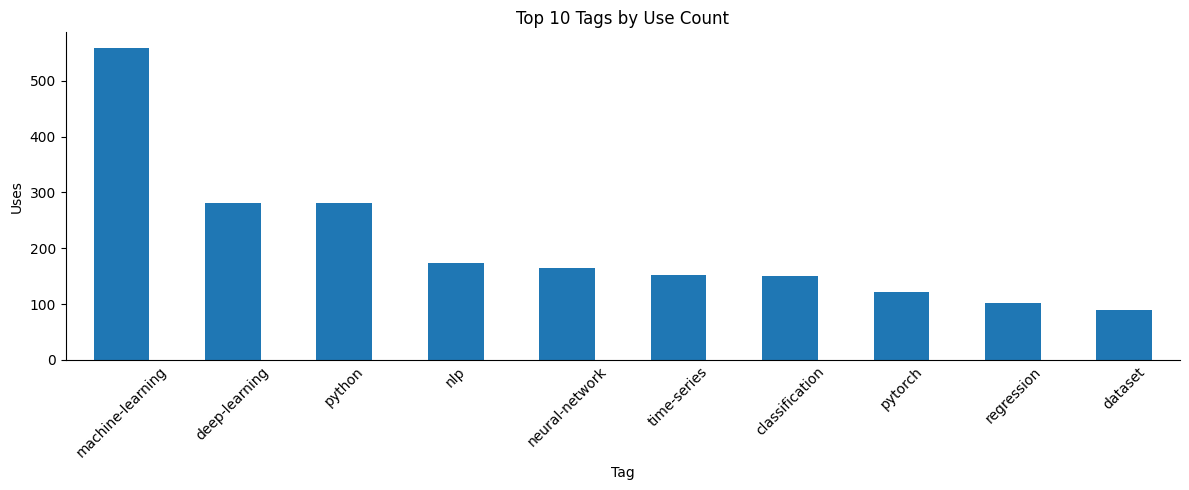

In [200]:
# Grab top 10 tags by use count
tag_uses_top_10 = tag_uses.sort_values(by='Uses', ascending=False).head(10)

# Plot top 10 tags
tag_uses_top_10.plot(kind='bar', figsize=(12, 5), rot=45, legend=False)

plt.xlabel('Tag')
plt.ylabel('Uses')
plt.title('Top 10 Tags by Use Count')

# Remove x-axis tick markers
plt.tick_params(axis='x', length=0)

sns.despine()
plt.tight_layout()
plt.savefig('visualizations/top_10_tags_by_use_count.png')
plt.show()

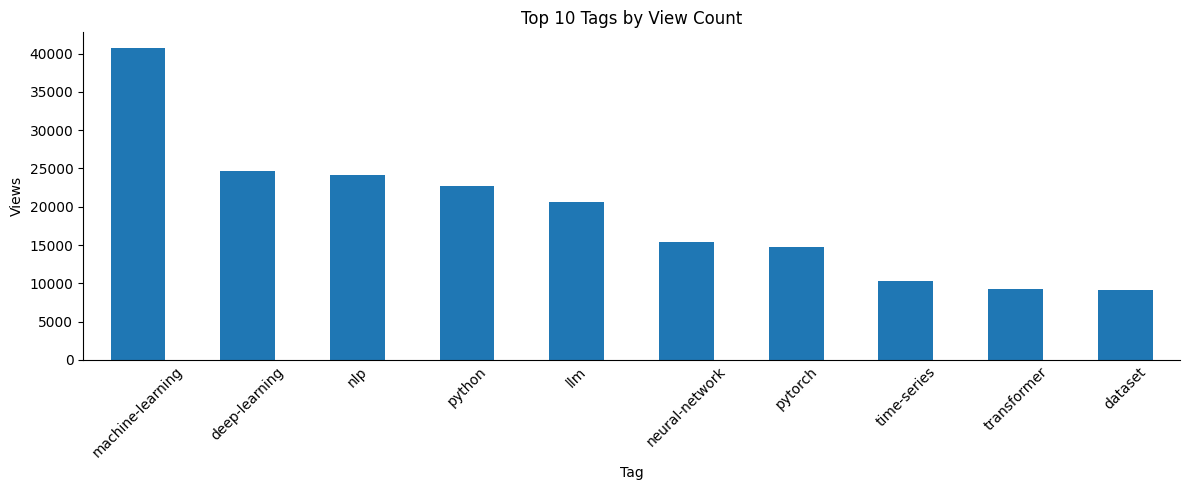

In [201]:
# Grab top 10 tags by view count
tag_views_top_10 = tag_views.sort_values(by='Views', ascending=False).head(10)

# Plot top 10 tags
tag_views_top_10.plot(kind='bar', figsize=(12, 5), rot=45, legend=False)

plt.xlabel('Tag')
plt.ylabel('Views')
plt.title('Top 10 Tags by View Count')

# Remove x-axis tick markers
plt.tick_params(axis='x', length=0)

sns.despine()
plt.tight_layout()
plt.savefig('visualizations/top_10_tags_by_view_count.png')
plt.show()

## Relationship Between Tags

We want to drill down into the relationship between specific tags in order to identify the best category for questions.
We will create a heatmap that visualizes occurrances between tags and shows most common ocurrences— focusing on the tags within the `tag_uses_top_10` dataframe.

In [202]:
# Get the top 10 tags from our existing dataframe
top_10_tags = tag_uses_top_10.index.tolist()

# Create a co-occurrence matrix initialized with zeros
cooccurrence_matrix = pd.DataFrame(0, index=top_10_tags, columns=top_10_tags)

In [203]:
# Fill the matrix by counting co-occurrences
for tags in df['Tags']:
    # Check if tags is a string, if not, convert it to a string
    if isinstance(tags, list):
        tag_list = tags
    else:
        # Split tags into list
        tag_list = tags.split()
    # Get intersection with our top 10 tags
    relevant_tags = [tag for tag in tag_list if tag in top_10_tags]
    # Count co-occurrences for each pair
    for i in range(len(relevant_tags)):
        for j in range(i + 1, len(relevant_tags)):
            cooccurrence_matrix.loc[relevant_tags[i], relevant_tags[j]] += 1
            cooccurrence_matrix.loc[relevant_tags[j], relevant_tags[i]] += 1

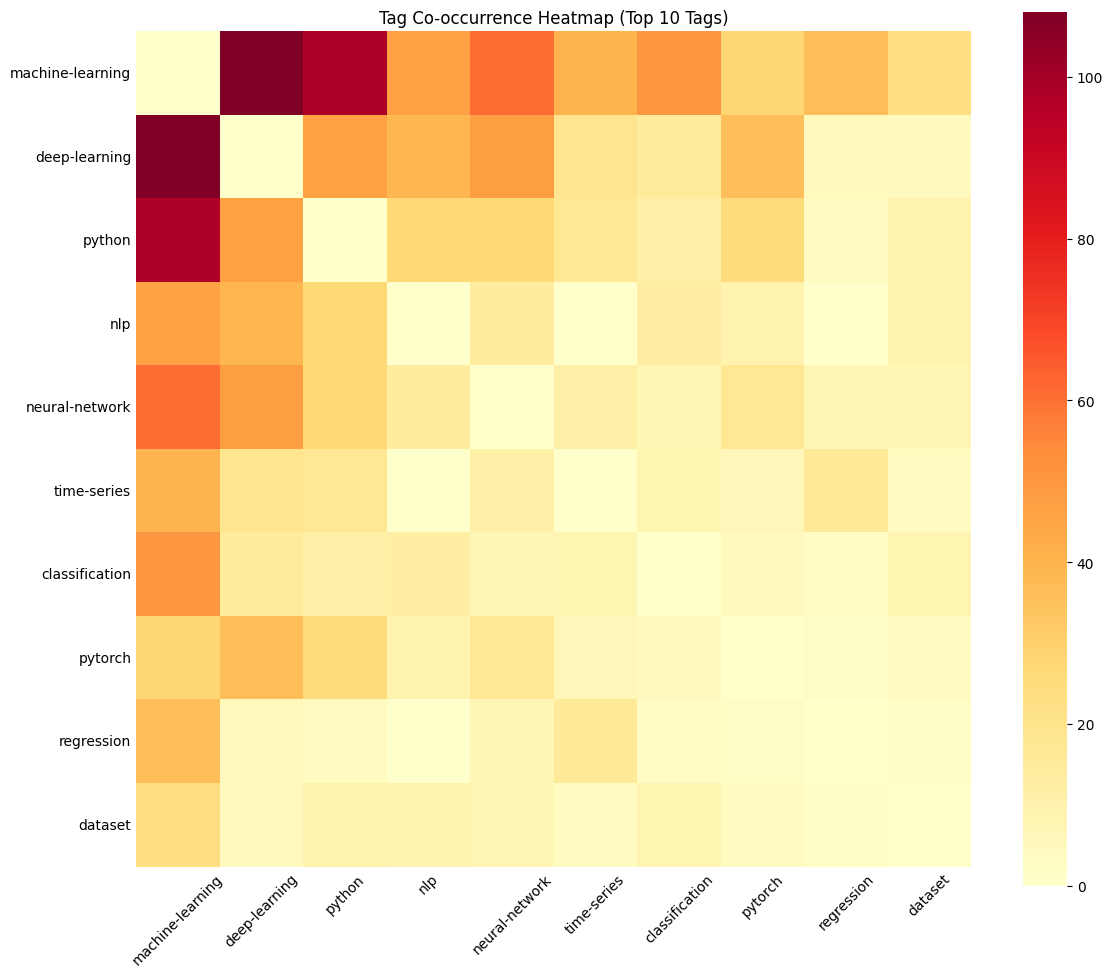

In [204]:
# Create the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cooccurrence_matrix, annot=False, cmap='YlOrRd', square=True)

plt.title('Tag Co-occurrence Heatmap (Top 10 Tags)')

plt.tick_params('both', length=0)
plt.tick_params('x', rotation=45)

plt.tight_layout()
plt.savefig('visualizations/tag_cooccurrence_heatmap.png')
plt.show()

From this heatmap, we can see that `machine-learning` and `deep-learning` co-occur with other top 10 tags within our dataframe. This indicates that these tags could encompass multiple topics that exhibit more popularity within Stack Exchange. We should narrow down into one of the top columns if we want to identify the most popular and relevant topic for our question.

## Narrowing Down `deep-learning` Tag

We use the following query to get all questions from SEDE. Our goal is to determine whether the `deep-learning` tag is a smart and long-lasting subject matter to base our top question upon.

```sql
SELECT Id, CreationDate, Tags
  FROM posts
 WHERE PostTypeId = 1;
```

This is saved into `all_questions.csv`

### Import `all_questions.csv` Into New DataFrame

In [205]:
df_all = pd.read_csv('all_questions.csv', parse_dates=['CreationDate'])

df_all.head()

,Id,CreationDate,Tags
0,87791,2021-01-11 09:32:20,<nlp><object-detection><document-understanding>
1,87792,2021-01-11 10:28:11,<python><scikit-learn><k-means>
2,87793,2021-01-11 10:29:08,<nlp><spacy><tokenization><information-extract...
3,87798,2021-01-11 11:29:28,<neural-network><lstm><overfitting>
4,87801,2021-01-11 12:07:36,<pytorch><torch>


### Clean `Tags` Column

We can use the same `clean_tags()` function that we created earlier in order to clean the new dataframe's `Tags` column.

In [206]:
df_all['Tags'] = df_all['Tags'].apply(clean_tags)

In [207]:
df_all.head()

,Id,CreationDate,Tags
0,87791,2021-01-11 09:32:20,"[nlp, object-detection, document-understanding]"
1,87792,2021-01-11 10:28:11,"[python, scikit-learn, k-means]"
2,87793,2021-01-11 10:29:08,"[nlp, spacy, tokenization, information-extract..."
3,87798,2021-01-11 11:29:28,"[neural-network, lstm, overfitting]"
4,87801,2021-01-11 12:07:36,"[pytorch, torch]"


## Identify Relevant Tags to `deep-learning`

In this section, we generate a list of unique tags in order to further drill down towards deep-learning subject matter. Our goal is to identify tags other than `deep-learning` that might also count towards the overall deep-learning category, as there may be related tags that we do not want to miss.

In [208]:
tag_list = df_all['Tags'].tolist()

tags_unique = []

for tags in tag_list:
    for tag in tags:
        if tag not in tags_unique:
            tags_unique.append(tag)

tags_unique

['nlp',
 'object-detection',
 'document-understanding',
 'python',
 'scikit-learn',
 'k-means',
 'spacy',
 'tokenization',
 'information-extraction',
 'neural-network',
 'lstm',
 'overfitting',
 'pytorch',
 'torch',
 'machine-learning',
 'optimization',
 'pandas',
 'preprocessing',
 'deep-learning',
 'tensorflow',
 'data-science-model',
 'ensemble-modeling',
 'ensemble',
 'stacking',
 'json',
 'clustering',
 'data',
 'feature-selection',
 'text-mining',
 'semantic-similarity',
 'stemming',
 'statistics',
 'multiclass-classification',
 'accuracy',
 'bagging',
 'random-forest',
 'linear-regression',
 'decision-trees',
 'cross-validation',
 'text-generation',
 'r',
 'metadata',
 'keras',
 'class-imbalance',
 'visualization',
 'bayesian',
 'regression',
 'correlation',
 'classification',
 'dataset',
 'image-classification',
 'machine-learning-model',
 'image',
 'kaggle',
 'labels',
 'annotation',
 'data-mining',
 'predictive-modeling',
 'gradient-descent',
 'feature-engineering',
 'xgboost

We will leverage the use of Generative AI to identify related tags to `deep-learning`. To do this, we will create a markdown file with all unique tags, then feed this markdown file into Claude 3.5 Sonnet to identify related tags to deep-learning.

In [209]:
# Save list as md
with open('tags_unique.md', 'w') as f:
    for tag in tags_unique:
        f.write(f'- {tag}\n')

<img src="screenshots/Screenshot 2024-12-17 170313.jpg"/>

We have identified the best related tags to the following:
- deep-learning
- neural-network
- pytorch
- tensorflow
- keras
- cuda

Now we can create a new feature within our dataframe to classify a row as deep-learning related.

## Create Feature: DeepLearning Column

In this section, we will create a new column, `DeepLearning`, to classify data as deep-learning related or not.

In [210]:
# Create classification function
def classify_deep_learning(row):
    for tag in row['Tags']:
        if tag in ['deep-learning', 'neural-network', 'pytorch', 'tensorflow', 'keras', 'cuda']:
            return 1
    return 0

# Apply function to df_all

df_all['DeepLearning'] = df_all.apply(classify_deep_learning, axis=1)

In [211]:
df_all.head()

,Id,CreationDate,Tags,DeepLearning
0,87791,2021-01-11 09:32:20,"[nlp, object-detection, document-understanding]",0
1,87792,2021-01-11 10:28:11,"[python, scikit-learn, k-means]",0
2,87793,2021-01-11 10:29:08,"[nlp, spacy, tokenization, information-extract...",0
3,87798,2021-01-11 11:29:28,"[neural-network, lstm, overfitting]",1
4,87801,2021-01-11 12:07:36,"[pytorch, torch]",1


## Deep Learning Questions Statistics

Using our newly created feature, we can filter our dataframe into only deep-learning related questions and identify the proportion of these questions against our overall number of questions.

In [212]:
# Create new dataframe for only DeepLearning
df_all_deep_learning = df_all[df_all['DeepLearning'] == 1]

# Store variables for question amounts
total_questions = len(df_all)
deep_learning_questions = len(df_all_deep_learning)

# Print results
print(f'Deep learning questions: {deep_learning_questions}')
print(f'Total questions: {total_questions}')
print(f'Percent of questions with deep learning tags: {round(deep_learning_questions / total_questions * 100, 2)}%')

Deep learning questions: 10276
Total questions: 36548
Percent of questions with deep learning tags: 28.12%


We can see that about 28.12% of questions posted in the last 12 months are deep-learning related. This is a good sign for our problem-case, as we aim to identify the most popular category to create a new question about.

## Visualization: Monthly Number of Questions

In this section, we want to identify how the number of questions regarding deep-learning has fluctuated within the last 12 months, on a monthly time basis.

In [216]:
# Group by month and aggregate by count of unique post id
df_all_deep_learning_monthly = df_all_deep_learning.groupby(df_all_deep_learning['CreationDate'].dt.month).agg({'Id': 'count'})

df_all_deep_learning_monthly.rename(columns={'Id': 'Count'}, inplace=True)

df_all_deep_learning_monthly

,Count
CreationDate,
1,908
2,844
3,933
4,870
5,991
6,869
7,905
8,879
9,731


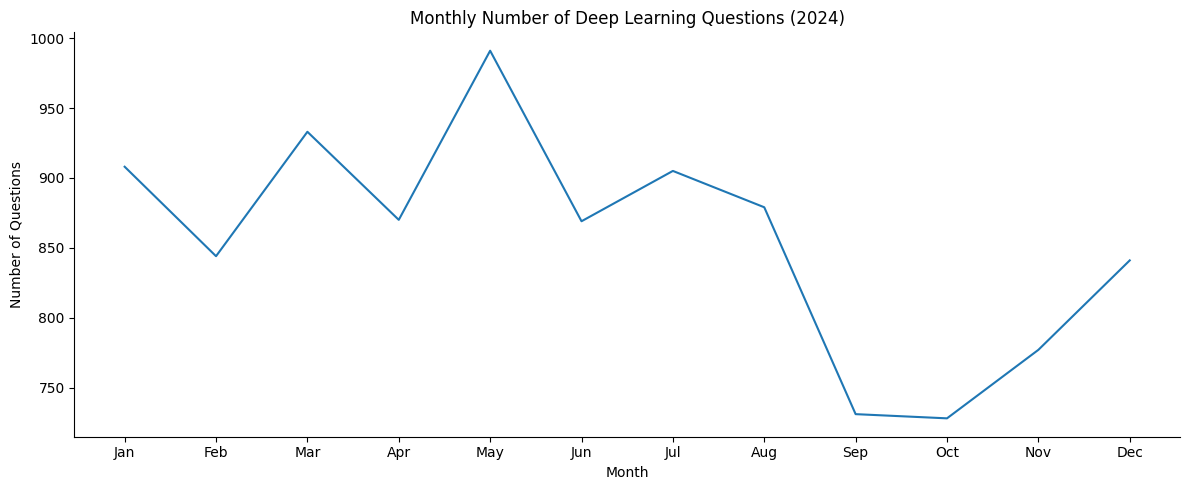

In [183]:
# Visualize on line graph
df_all_deep_learning_monthly.plot(kind='line', figsize=(12, 5), legend=False)

plt.xlabel('Month')
plt.ylabel('Number of Questions')
plt.title('Monthly Number of Deep Learning Questions (2024)')

plt.xticks(
    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
)

sns.despine()
plt.tight_layout()
plt.show()

## Visualize Proportion of Deep Learning Questions Against Total Questions

In this section, we aim to visualize similarly to above, but on the proportion of deep-learning questions versus total. This will give us a better picture whether deep-learning related questions are still popular and how its popularity has changed in comparison to unrelated topics.